# 1. 결정트리

## 1. 데이터셋 불러오기 및 전처리

화이트와인(클래스:1) 레드와인(클래스:2) 구분하는 과제
https://itstory1592.tistory.com/13


In [1]:
import pandas as pd

wine = pd.read_csv('https://bit.ly/wine_csv_data')
wine.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [3]:
wine.info()

data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


In [5]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

In [7]:
# 비교를 위한 로지스틱 회귀
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

lr = LogisticRegression()
lr.fit(train_scaled, train_target)
print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))
print(lr.coef_, lr.intercept_)

0.7808350971714451
0.7776923076923077
[[ 0.51270274  1.6733911  -0.68767781]] [1.81777902]


가중치 순서: 알코올, 당도, ph

가중치 분석 결과 알코올과 당도가 클수록 양성 클래스(화이트 와인)일 가능성이 높아지고, ph가 클 수록 음성 클래스(레드 와인)을 가능성이 높다.

## 문제1
결정 트리는 로지스틱 회귀와 달리 데이터 scaling 과정이 필요 없다. 그 이유를 작성해주세요

답: 로지스틱 회귀의 경우 가중치와 데이터간의 곱의 합으로 연결되어있어 가중치 업데이트 과정에서 특정 가중치만 크게 변화하여 결과값에 특정 열만 편향적으로 영향을 끼칠 수 있다. 결정트리의 경우 각 열마다 독립적으로 기준값을 기준으로 데이터를 분류하므로 데이터간의 단위나 범위 차이가 심하더라도 상관없다. 따라서 결정트리는 따로 data scaling이 필요없다.

In [13]:
# 결정 트리
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_scaled, train_target)
print(dt.score(train_scaled, train_target))
print(dt.score(test_scaled, test_target))


0.996921300750433
0.8592307692307692


## 2. 결정트리 그래프로 확인
로지스틱 회귀 점수에 비해 결정트리에서 매우 높은 점수가 나타났다. 과대적합이 의심된다

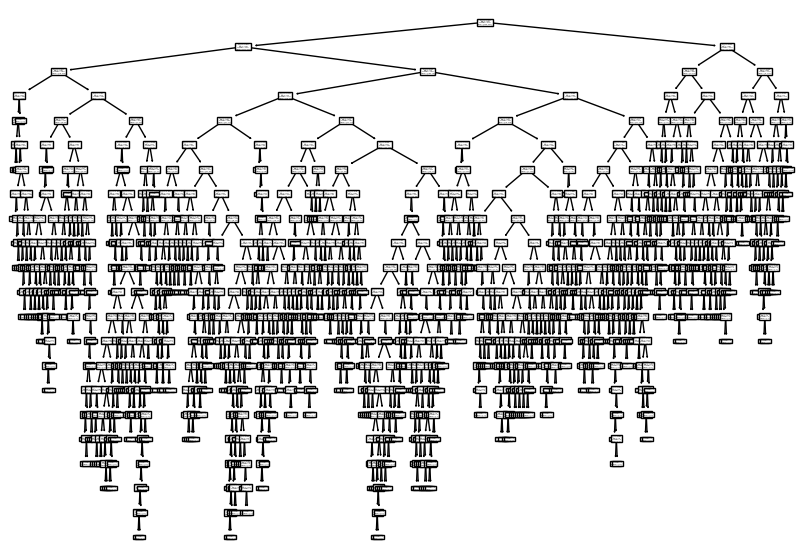

In [16]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(10,7))
plot_tree(dt)
plt.show()

## 3. 가지치기 pruning
가지치기를 사용하여 오버피팅된 결정트리를 최적화하기




## 문제 2 코드를 완성하세요

In [22]:
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
#깊이를 조정하는 방법
dt.fit(train_input, train_target)

print(dt.score(train_input, train_target))
print(dt.score(test_input, test_target))

0.8454877814123533
0.8415384615384616


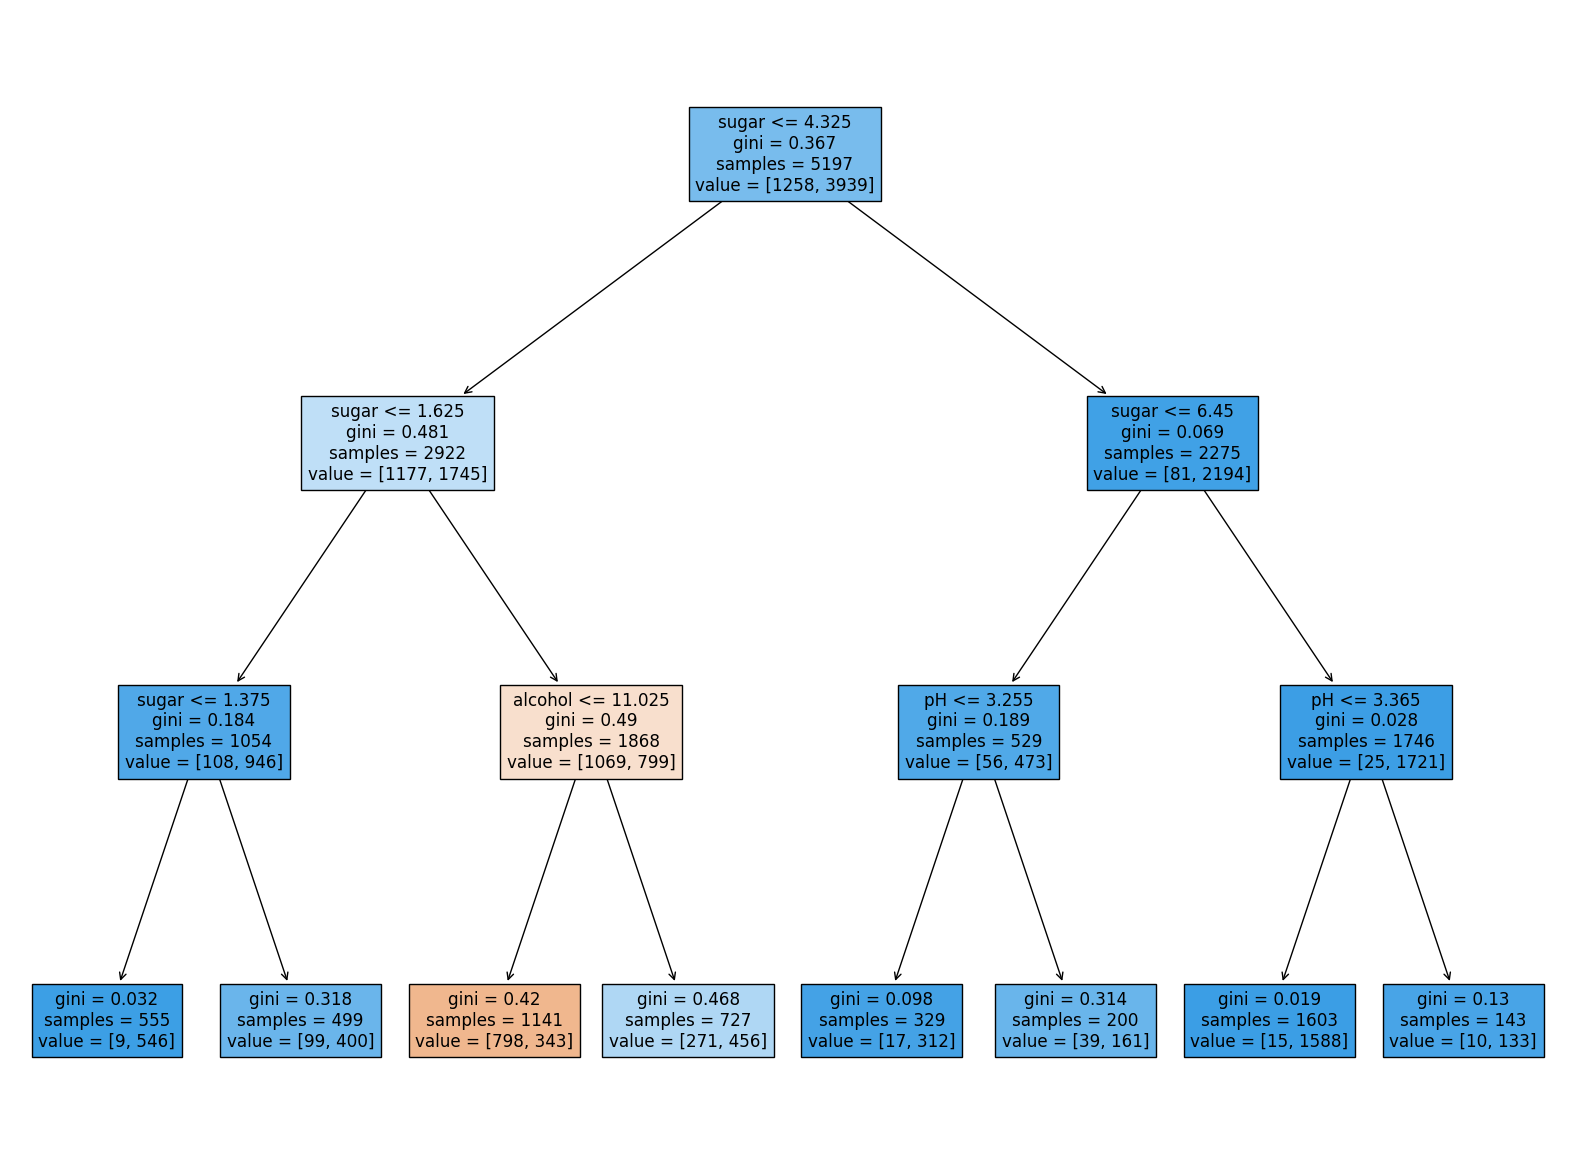

In [24]:
plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

In [26]:
# 특성 중요도
print('  alcohol      sugar       pH')
print(dt.feature_importances_)

  alcohol      sugar       pH
[0.12345626 0.86862934 0.0079144 ]


In [28]:
#하이퍼파라미터 값을 위한 그리드 서치


from sklearn.model_selection import GridSearchCV
import numpy as np

params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
          'max_depth': range(5, 20, 1),
          'min_samples_split': range(2, 100, 10)
          }

# min_impurity_decrease : 최소 불순도
# min_impurity_split : 나무 성장을 멈추기 위한 임계치
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

print(gs.best_params_)

dt = gs.best_estimator_
print(dt.score(test_input, test_target))

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}
0.8615384615384616


# 2. SVM

암 진단이 양성인지 악성인지 여러 관찰/특징에 기초하여 예측한다.
30가지 기능이 사용되며, 예:
- 반지름(둘레의 중심에서 점까지의 거리 mean)
- 텍스처(회색 스케일 값의 표준 편차)
- 둘레의면적
- 평활도(반지름 길이의 국부적 변화)
- 콤팩트성 (perimeter^2 / 면적 - 1.0)
- 오목한 부분(윤곽의 오목한 부분의 severity)
- 오목한 점(윤곽의 오목한 부분의 수)
- 대칭성
- 프랙탈 차원("coastline 근사" - 1)

대상 클래스: 악성, 양성


## 1. 데이터 불러오기

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer

cancer=load_breast_cancer()
df_cancer=pd.DataFrame(np.c_[cancer['data'], cancer['target']], columns= np.append(cancer['feature_names'], ['target']))
df_cancer.head()



,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [113]:
df_cancer.nunique()

mean radius                456
mean texture               479
mean perimeter             522
mean area                  539
mean smoothness            474
mean compactness           537
mean concavity             537
mean concave points        542
mean symmetry              432
mean fractal dimension     499
radius error               540
texture error              519
perimeter error            533
area error                 528
smoothness error           547
compactness error          541
concavity error            533
concave points error       507
symmetry error             498
fractal dimension error    545
worst radius               457
worst texture              511
worst perimeter            514
worst area                 544
worst smoothness           411
worst compactness          529
worst concavity            539
worst concave points       492
worst symmetry             500
worst fractal dimension    535
target                       2
dtype: int64

## 2. 데이터 시각화

C:\Users\USER\Anaconda_\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


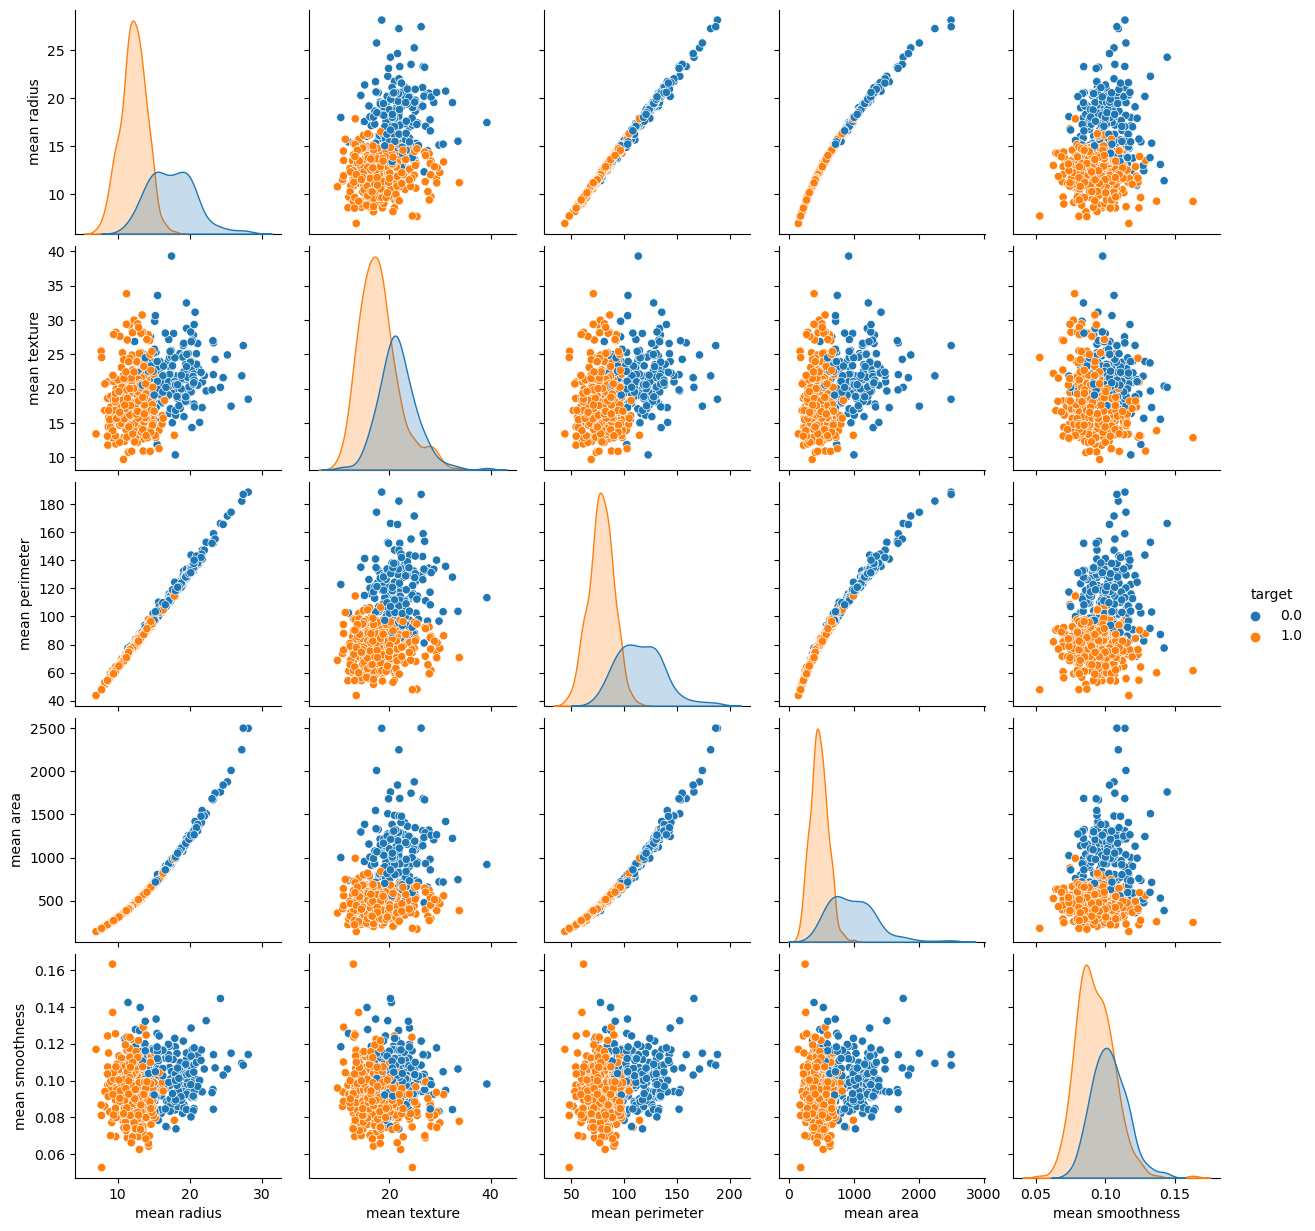

In [33]:
sns.pairplot(df_cancer, hue = 'target', vars = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness'])

<Axes: >

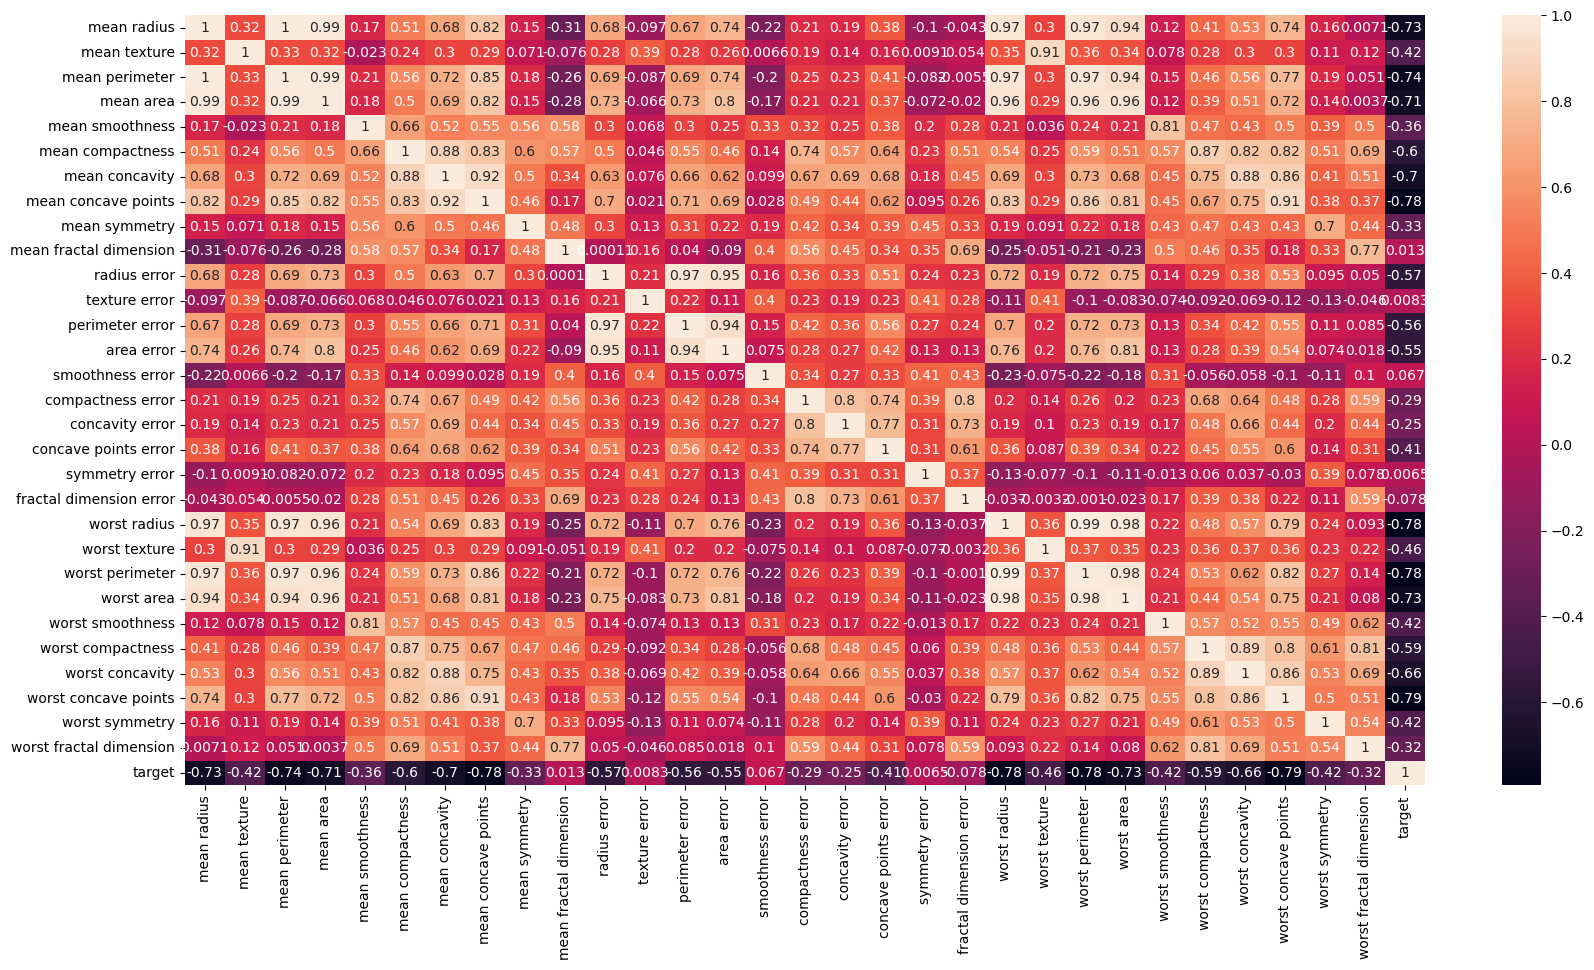

In [35]:
plt.figure(figsize=(20,10))
sns.heatmap(df_cancer.corr(), annot=True)

## 3. 학습

In [169]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

X=df_cancer.drop(['target'], axis=1)
y=df_cancer['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svc_model=SVC()
svc_model.fit(X_train, y_train)

SVC()

<Axes: >

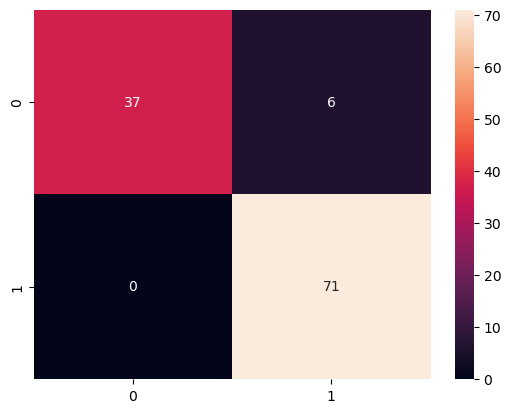

In [171]:
y_predict=svc_model.predict(X_test)
cm=confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True)

## 4. 모델 개선

<Axes: >

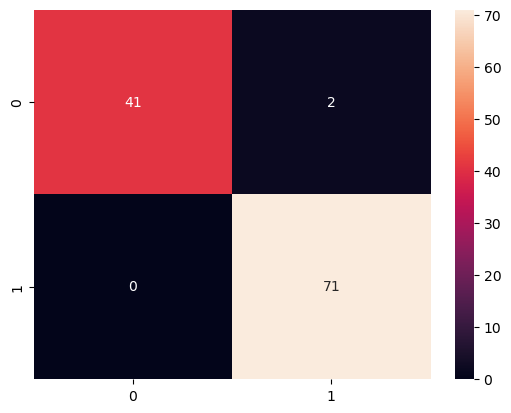

In [173]:
# scaling

from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

svc_model.fit(X_train_scaled, y_train)
y_predict=svc_model.predict(X_test_scaled)
cm=confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot=True, fmt="d")

## 문제 3
confusion matrix 개선을 위한 다른 방법을 제시해주세요. 아래에 코드로 작성해주세요.

hyperparameter tuning을 실시한다

In [181]:
from sklearn.model_selection import GridSearchCV

# Grid Search for Classification
param_grid_cls = {'C': [0.1,1,3,5,7,9,50,100,500,1000], 'kernel': ['linear', 'rbf','poly']}

grid_cls = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid_cls,
    cv=3
)

grid_cls.fit(X_train_scaled, y_train)
best_cls = grid_cls.best_estimator_
print("Best parameters (classification):", grid_cls.best_params_)

y_pred = best_cls.predict(X_test_scaled)
print("Classification Accuracy:", accuracy_score(y_test, y_pred))

Best parameters (classification): {'C': 1, 'kernel': 'rbf'}
Classification Accuracy: 0.9824561403508771


In [183]:
pred = best_cls.predict(X_test_scaled)

accuracy = np.round(accuracy_score(y_test, pred),4)
cm = confusion_matrix(y_test, pred)

<Axes: >

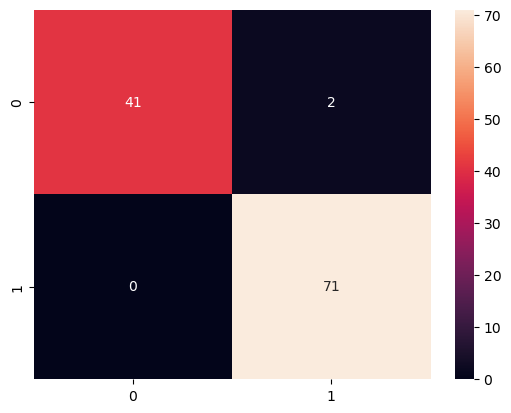

In [185]:
sns.heatmap(cm, annot=True, fmt="d")

다른 모델로 분류한다

In [117]:
from sklearn.ensemble import RandomForestClassifier

In [135]:
rf = RandomForestClassifier(random_state=42)

# Grid Search
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [5,10, 20],
    'min_samples_split': [2, 5, 8],
    'criterion': ['gini', 'entropy']
}

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_rf.fit(X_train_scaled, y_train)
best_rf = grid_rf.best_estimator_

print("Best hyperparameters for RandomForest:", grid_rf.best_params_)

Best hyperparameters for RandomForest: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


In [137]:
pred = best_rf.predict(X_test_scaled)

accuracy = np.round(accuracy_score(y_test, pred),4)
cm = confusion_matrix(y_test, pred)

<Axes: >

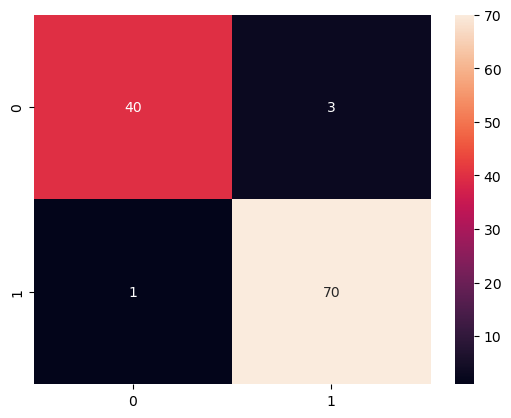

In [139]:
sns.heatmap(cm, annot=True, fmt="d")